In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Use SQLAlchemy `create_engine` to connect to your sqlite database.

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

##### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [10]:
conn = engine.connect()
#added total_prcp by date
measurements = pd.read_sql("Select *, sum(prcp) as total_prcp From measurement group by date order by date desc" ,conn)
measurements.head()
measurements.dtypes

#changing date coulmn to datetime format
measurements['date'] = pd.to_datetime(measurements['date'])
measurements.dtypes

measurements.head()

,id,station,date,prcp,tobs,total_prcp
0,2724,USC00519397,2017-08-23,0.0,81.0,0.53
1,2723,USC00519397,2017-08-22,0.0,82.0,0.50
2,2722,USC00519397,2017-08-21,0.0,81.0,0.58
3,2721,USC00519397,2017-08-20,0.0,81.0,0.01
4,2720,USC00519397,2017-08-19,0.0,79.0,0.09


##### Calculate the date 1 year ago from the last data point in the database

In [11]:
twelve_months_ago = measurements['date'].max() - pd.DateOffset(months=11)
print(twelve_months_ago)

2016-09-23 00:00:00


###### Perform a query to retrieve the data and precipitation scores


In [12]:
twelve_month_data = measurements.loc[measurements['date'] > twelve_months_ago]
tmd = twelve_month_data[['date','total_prcp']]
tmd.head()

,date,total_prcp
0,2017-08-23,0.53
1,2017-08-22,0.50
2,2017-08-21,0.58
3,2017-08-20,0.01
4,2017-08-19,0.09


##### Save the query results as a Pandas DataFrame and set the index to the date column


In [13]:
twelve = pd.DataFrame(tmd)
twelve = twelve.set_index('date')
twelve.sort_index()
twelve.head()

,total_prcp
date,
2017-08-23,0.53
2017-08-22,0.50
2017-08-21,0.58
2017-08-20,0.01
2017-08-19,0.09


##### Sort the dataframe by date


In [14]:
twelve = twelve.sort_index()
twelve.head()


,total_prcp
date,
2016-09-24,0.28
2016-09-25,0.09
2016-09-26,1.67
2016-09-27,1.36
2016-09-28,0.13


##### Use Pandas Plotting with Matplotlib to plot the data


In [15]:
#prepping data to be plotted

#decided to add the prcp scores by month.
twelve = twelve.resample('M').sum()
twelve

tmd_sum = pd.DataFrame(twelve)
tmd_sum
tmd_sum = tmd_sum.reset_index()
print(tmd_sum)

date = tmd_sum['date'].astype(str).tolist()
prcp = tmd_sum['total_prcp'].tolist()

         date  total_prcp
0  2016-09-30        7.67
1  2016-10-31       21.77
2  2016-11-30       20.56
3  2016-12-31       35.51
4  2017-01-31       11.95
5  2017-02-28       39.06
6  2017-03-31       29.62
7  2017-04-30       54.91
8  2017-05-31       25.27
9  2017-06-30       20.52
10 2017-07-31       23.72
11 2017-08-31        5.18


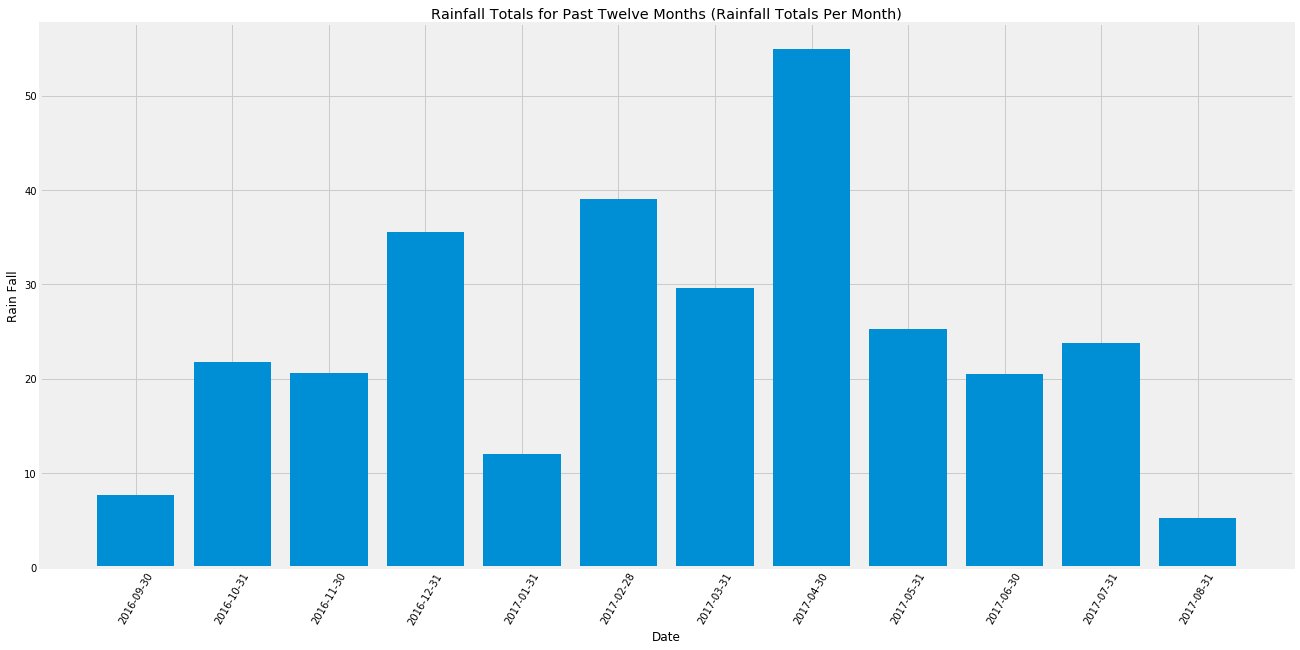

In [16]:
#plotting
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(date,prcp)
ax.set_title("Rainfall Totals for Past Twelve Months (Rainfall Totals Per Month)")
plt.xticks(date,rotation=60)
ax.set_xlabel("Date")
ax.set_ylabel("Rain Fall")
plt.show()

In [17]:
#plotting again to look like example .png 

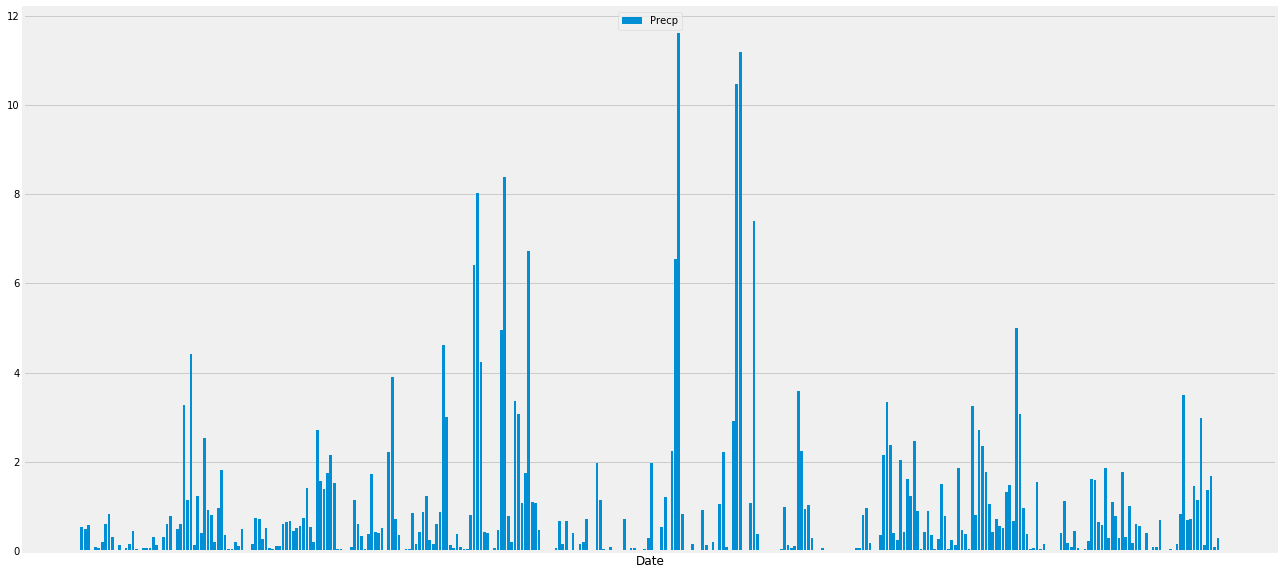

In [18]:
fig1, ax1 = plt.subplots(figsize=(20,10))

date1 = tmd['date'].astype(str).tolist()
prcp1 = tmd['total_prcp'].tolist()

ax1.bar(date1,prcp1)
plt.xlabel('Date')
#ax1.xaxis.set_visible(False)
ax1.set_xticks([])
ax1.legend(['Precp'],loc=9)
plt.show()


![precipitation](Images/precipitation.png)

##### Use Pandas to calcualte the summary statistics for the precipitation data

In [56]:
tmd_sum.describe()

,total_prcp
count,12.000000
mean,24.645000
std,13.941357
min,5.180000
25%,18.377500
50%,22.745000
75%,31.092500
max,54.910000


##### Design a query to show how many stations are available in this dataset?


In [60]:
stations_count = pd.read_sql("Select count(distinct station) as '# Of Stations' from station" ,conn)
print(stations_count)

#or 
print(" ")

stations = session.query(func.count(Station.station)).all()
print(f'There are {stations} stations.')

   # Of Stations
0              9
 
There are [(9,)] stations.


##### What are the most active stations? (i.e. what stations have the most rows)?
###### List the stations and the counts in descending order.

In [93]:
stations = pd.read_sql("Select station,id, count(station) as 'Activity Count' from measurement group by station order by 3 desc",conn)
stations

,station,id,Activity Count
0,USC00519281,12188,2772
1,USC00519397,1,2724
2,USC00513117,2725,2709
3,USC00519523,9519,2669
4,USC00516128,16939,2612
5,USC00514830,5434,2202
6,USC00511918,14960,1979
7,USC00517948,7636,1372
8,USC00518838,9008,511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [31]:
# Plot the daily normals as an area plot with `stacked=False`
